In [3]:
%run batter_data.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objs as go
import xgboost
import shap
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from statsmodels import tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import IsolationForest
from plotly.offline import plot
from plotly.offline import init_notebook_mode
from tensorflow import keras


init_notebook_mode(connected = True)

feature, target = batter_data("SK")

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning:

In [6]:
feature.columns

Index(['RBI', 'BB', 'MONEY_BAT', 'AGE_VA_BAT', 'K/PA', 'BABIP_BAT', 'BPF',
       'BS_PCA', 'PA_PCA', 'LB_PCA'],
      dtype='object')

In [31]:
trainFeature = feature.loc[0:feature.shape[0]-20]
trainTarget = target.loc[0:feature.shape[0]-20]

testFeature = feature.loc[feature.shape[0]-20:].reset_index(drop = True)
testTarget = target[feature.shape[0]-20:].reset_index(drop = True)
trainFeature.shape

(522, 13)

In [ ]:
scaler = MinMaxScaler()
res = scaler.fit(trainFeature)
res = scaler.transform(trainFeature)
trainFeature = pd.DataFrame(res, columns = trainFeature.columns, index = list(trainFeature.index.values))
res = scaler.transform(testFeature)
testFeature = pd.DataFrame(res, columns = testFeature.columns, index = list(testFeature.index.values))

res = scaler.fit(np.array(trainTarget).reshape(trainTarget.shape[0], 1))
trainTarget = scaler.transform(np.array(trainTarget).reshape(trainTarget.shape[0], 1))
testTarget = scaler.transform(np.array(testTarget).reshape(testTarget.shape[0], 1))

In [52]:
model = keras.Sequential()
model.add(keras.layers.Input(shape = trainFeature.shape[1]))
model.add(keras.layers.Dense(16, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(64, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(128, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(128, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(128, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(64, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(16, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(8, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(2, activation = "relu"))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(1, activation = None))
model.compile(optimizer = "Adam", loss = "mse")

early_stopping = keras.callbacks.EarlyStopping(min_delta = 0.0005, patience = 30, restore_best_weights = True)

history = model.fit(trainFeature, trainTarget, epochs = 200, validation_split = 0.3, shuffle = True,
          use_multiprocessing = True, callbacks = [early_stopping], batch_size = 10)

In [53]:
result = model.predict(testFeature).reshape(testTarget.shape[0], )

Train on 365 samples, validate on 157 samples
Epoch 1/500
365/365 [==============================] - ETA: 1s - loss: 0.234 - 0s 967us/sample - loss: 0.1687 - val_loss: 0.0266
Epoch 2/500
365/365 [==============================] - ETA: 0s - loss: 0.242 - 0s 123us/sample - loss: 0.1575 - val_loss: 0.0228
Epoch 3/500
365/365 [==============================] - ETA: 0s - loss: 0.136 - 0s 142us/sample - loss: 0.1381 - val_loss: 0.0199
Epoch 4/500
365/365 [==============================] - ETA: 0s - loss: 0.079 - 0s 145us/sample - loss: 0.1315 - val_loss: 0.0178
Epoch 5/500
365/365 [==============================] - ETA: 0s - loss: 0.116 - 0s 139us/sample - loss: 0.1152 - val_loss: 0.0164
Epoch 6/500
365/365 [==============================] - ETA: 0s - loss: 0.076 - 0s 137us/sample - loss: 0.1072 - val_loss: 0.0156
Epoch 7/500
365/365 [==============================] - ETA: 0s - loss: 0.119 - 0s 158us/sample - loss: 0.1058 - val_loss: 0.0151
Epoch 8/500
365/365 [==============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 - 0s 101us/sample - loss: 0.0074 - val_loss: 0.0063
Epoch 297/500
365/365 [==============================] - ETA: 0s - loss: 0.005 - 0s 99us/sample - loss: 0.0072 - val_loss: 0.0063
Epoch 298/500
365/365 [==============================] - ETA: 0s - loss: 0.009 - 0s 96us/sample - loss: 0.0071 - val_loss: 0.0063
Epoch 299/500
365/365 [==============================] - ETA: 0s - loss: 0.003 - 0s 115us/sample - loss: 0.0071 - val_loss: 0.0063
Epoch 300/500
365/365 [==============================] - ETA: 0s - loss: 0.006 - 0s 112us/sample - loss: 0.0071 - val_loss: 0.0063
Epoch 301/500
365/365 [==============================] - ETA: 0s - loss: 0.007 - 0s 110us/sample - loss: 0.0072 - val_loss: 0.0063
Epoch 302/500
365/365 [==============================] - ETA: 0s - loss: 0.011 - 0s 107us/sample - loss: 0.0075 - val_loss: 0.0063
Epoch 303/500
365/365 [==============================] - ETA: 0s - loss: 0.006 - 0s 95us/sample - loss: 0.0072 - val_loss: 0.0063
Epoch 304/500
365/365 [==========

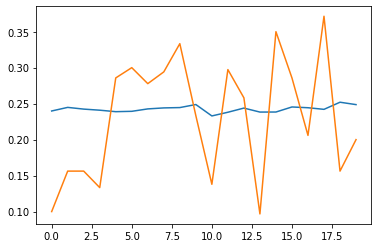

In [6]:
plt.plot(result)
plt.plot(testTarget)

In [7]:
result.mean()

0.2424927931725979

In [8]:
testTarget.mean()

0.23147259810461981

In [58]:
trainTarget.mean()

0.2692132705502485

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])